In [119]:
import requests, bs4

from bs4 import BeautifulSoup as bs

import pandas as pd 
import numpy as np
import re, os
from time import sleep

import pickle as pkl

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, model_selection
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path
%matplotlib inline

In [2]:
# findTables and pullTable were borrowed from
# https://github.com/BenKite/baseball_data/blob/master/baseballReferenceScrape.py

def findTables(url):
    res = requests.get(url)
    ## comments break parsing.  Next 2 comments fix that
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    divs = soup.findAll('div', id = "content")
    divs = divs[0].findAll("div", id=re.compile("^all"))
    ids = []
    for div in divs:
        searchme = str(div.findAll("table"))
        x = searchme[searchme.find("id=") + 3: searchme.find(">")]
        x = x.replace("\"", "")
        if len(x) > 0:
            ids.append(x)
            
    return(ids)

def pullTable(url, tableID):
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text))
    tables = soup.findAll('table', id = tableID)
    data_rows = tables[0].findAll('tr')
    data_header = tables[0].findAll('thead')
    data_header = data_header[0].findAll("tr")
    data_header = data_header[0].findAll("th")
    game_data = [[td.getText() for td in data_rows[i].findAll(['th','td'])]
        for i in range(len(data_rows))
        ]
    data = pd.DataFrame(game_data)
    header = []
    for i in range(len(data.columns)):
        header.append(data_header[i].getText())
    data.columns = header
    data = data.loc[data[header[0]] != header[0]]
    data = data.reset_index(drop = True)
    
    return(data)

def Get_Season_Batting_Stats(batter_df):
    df_dict={}
    for i in range(0, len(batter_df)):
        url = batter_df['URL'][i]
        batter_data = pullTable(url, "players_standard_batting")
        sleep(3)
        df_dict[batter_df['Year'][i]] = batter_data
        
    return df_dict

def Get_Batting_Stats(batter_df):
    df_dict={}
    for i in range(0, len(batter_df)):
        url = batter_df['URL'][i]
        batter_data = pullTable(url, "batting_standard")
        sleep(3)
        df_dict[batter_df['Player'][i]] = batter_data
        
    return df_dict

def Get_Adv_Batting_Stats(batter_df):
    df_dict={}
    for i in range(0, len(batter_df)):
        url = batter_df['URL'][i]
        batter_data = pullTable(url, "batting_advanced")
        sleep(3)
        df_dict[batter_df['Player'][i]] = batter_data
        
    return df_dict

In [87]:
# test 
# d = {'Year': ['2020','2021'], 'URL':['https://www.baseball-reference.com/leagues/majors/2020-standard-batting.shtml', 'https://www.baseball-reference.com/leagues/majors/2021-standard-batting.shtml']}

# Full Pull

years = list(range(1946,2022))
years = [str(x) for x in years]
urls = []
for i in years:
    urls.append('https://www.baseball-reference.com/leagues/majors/' + i +'-standard-batting.shtml')
    
d = {'Year': years, 'URL': urls}


url_df = pd.DataFrame(data=d)

In [88]:
df = Get_Season_Batting_Stats(url_df)

In [42]:
df['2021'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rk           1724 non-null   object
 1   Name         1724 non-null   object
 2   Age          1724 non-null   object
 3   Tm           1724 non-null   object
 4   Lg           1724 non-null   object
 5   G            1724 non-null   object
 6   PA           1724 non-null   object
 7   AB           1724 non-null   object
 8   R            1724 non-null   object
 9   H            1724 non-null   object
 10  2B           1724 non-null   object
 11  3B           1724 non-null   object
 12  HR           1724 non-null   object
 13  RBI          1724 non-null   object
 14  SB           1724 non-null   object
 15  CS           1724 non-null   object
 16  BB           1724 non-null   object
 17  SO           1724 non-null   object
 18  BA           1724 non-null   object
 19  OBP          1724 non-null 

In [89]:
# Don't run more than once 
# Adds year column to data and drops season avg row.

year_list = d['Year']

master_list = pd.DataFrame()

for i in year_list:
    df[i] = df[i].iloc[:-1, :]
    df[i]['Year'] = i
    master_list = master_list.append(df[i], ignore_index=True)


In [90]:
# create save file for master_list
# master_list.to_csv('test_batter.csv', index=False)
# master_list.to_csv('master_batter.csv', index=False)

In [3]:
# using pandas
# read in master_list to avoid scrape

# master_list = pd.read_csv("test_batter.csv")
master_list = pd.read_csv("master_batter.csv")

D:\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
master_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76477 entries, 0 to 76476
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rk           76477 non-null  int64  
 1   Name         76477 non-null  object 
 2   Age          76477 non-null  object 
 3   Tm           76477 non-null  object 
 4   Lg           76477 non-null  object 
 5   G            76477 non-null  int64  
 6   PA           76477 non-null  int64  
 7   AB           76477 non-null  int64  
 8   R            76477 non-null  int64  
 9   H            76477 non-null  int64  
 10  2B           76477 non-null  int64  
 11  3B           76477 non-null  int64  
 12  HR           76477 non-null  int64  
 13  RBI          76477 non-null  int64  
 14  SB           76477 non-null  int64  
 15  CS           75501 non-null  float64
 16  BB           76477 non-null  int64  
 17  SO           75497 non-null  float64
 18  BA           67036 non-null  float64
 19  OBP 

In [177]:
# clean data by removing special characters from end of name, filling in missing values, and converting to int and floats
count = 0
for name in master_list['Name']:
    if name[-1] == '#' or name[-1] == '*' or name[-1] == '?':
        master_list['Name'][count] = name[:-1]
    count += 1

master_list= master_list.fillna(0)    
for col in master_list:
    master_list[col] = pd.to_numeric(master_list[col], errors='ignore')

C:\Users\Billy\AppData\Local\Temp/ipykernel_16092/902772370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_list['Name'][count] = name[:-1]


In [178]:
# only run once
# drop Rk column
master_list.drop(['Rk'], axis=1, inplace=True)

In [185]:
# drop rows that have 'TOT' for team to avoind double counting

master_list = master_list[master_list['Tm'] != 'TOT']

In [187]:
# create csv for cleaned data

master_list.to_csv('clean_batter.csv', index=False)

In [8]:
#create json for cleaned data

master_list.to_json('clean_batter.json')

In [ ]:
# load in cleaned csv
master_list = pd.read_csv("clean_batter.csv")

In [6]:
master_list.head()

,Name,Age,Tm,Lg,G,PA,AB,R,H,2B,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary,Year
0,Woody Abernathy,31,NYG,NL,15,8,8,0,0,0,...,0.000,-100.0,0,0.0,0,0,0.0,0.0,1,1946
1,Ace Adams,36,NYG,NL,3,0,0,0,0,0,...,0.000,0.0,0,0.0,0,0,0.0,0.0,/1,1946
2,Bobby Adams,24,CIN,NL,94,346,311,35,76,13,...,0.636,82.0,107,7.0,3,14,0.0,1.0,4H/95,1946
3,Buster Adams,31,STL,NL,81,209,173,21,32,6,...,0.619,73.0,53,3.0,3,4,0.0,2.0,87H,1946
4,Emery Adams,35,NBY,NN2,1,0,0,0,0,0,...,0.000,0.0,0,0.0,0,0,0.0,0.0,/1,1946


In [9]:
master_list.iloc[45:51]

,Name,Age,Tm,Lg,G,PA,AB,R,H,2B,...,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary,Year
45,Russ Bauers,32,CHC,NL,15,12,10,1,3,1,...,0.817,134.0,4,0.0,0,0,0.0,0.0,1,1946
46,Johnny Beazley,28,STL,NL,19,38,33,2,8,1,...,0.558,56.0,9,1.0,0,3,0.0,0.0,1,1946
47,Heinz Becker,30,CHC,NL,9,8,7,0,2,0,...,0.661,90.0,2,0.0,0,0,0.0,0.0,/H,1946
48,Heinz Becker,30,CLE,AL,50,172,147,15,44,10,...,0.782,126.0,56,2.0,2,0,0.0,2.0,3/H,1946
49,Joe Beggs,35,CIN,NL,28,74,63,4,14,2,...,0.523,51.0,16,0.0,0,7,0.0,0.0,1,1946
50,Hank Behrman,25,BRO,NL,47,48,42,1,4,0,...,0.232,-34.0,4,0.0,0,4,0.0,0.0,1,1946


In [10]:
# import pymongo to manage database
from pymongo import MongoClient
from pprint import pprint


In [11]:
client = MongoClient()

In [13]:
batters = client.batting
batters.list_collection_names()

['stats']

In [14]:
stats = batters.stats

In [37]:
list(stats.find().limit(1))

[{'_id': ObjectId('623adeda984b65fbacf6db5f'),
  'Name': 'Woody\xa0Abernathy',
  'Age': 31,
  'Tm': 'NYG',
  'Lg': 'NL',
  'G': 15,
  'PA': 8,
  'AB': 8,
  'R': 0,
  'H': 0,
  '2B': 0,
  '3B': 0,
  'HR': 0,
  'RBI': 0,
  'SB': 0,
  'CS': 0.0,
  'BB': 0,
  'SO': 4.0,
  'BA': 0.0,
  'OBP': 0.0,
  'SLG': 0.0,
  'OPS': 0.0,
  'OPS+': -100.0,
  'TB': 0,
  'GDP': 0.0,
  'HBP': 0,
  'SH': 0,
  'SF': 0.0,
  'IBB': 0.0,
  'Pos\xa0Summary': 1,
  'Year': 1946}]

In [18]:
len(list(stats.distinct('Age')))

39

In [48]:
HomersPerYear = list(stats.aggregate([
                    {'$group' : {'_id': '$Year', 'HR': {'$sum':'$HR'}}},
                    {'$sort':{'_id': 1}}
                    ]))
HomerDF = pd.DataFrame(HomersPerYear)

In [117]:
HomersPerYear[0:5]

[{'_id': 1946, 'HR': 1346},
 {'_id': 1947, 'HR': 1715},
 {'_id': 1948, 'HR': 1675},
 {'_id': 1949, 'HR': 1704},
 {'_id': 1950, 'HR': 2073}]

In [47]:
PAPerYear = list(stats.aggregate([
                {'$group' : {'_id': '$Year', 'PA': {'$sum':'$PA'}}},
                {'$sort':{'_id': 1}}
                ]))

PAPerYear[0]

{'_id': 1946, 'PA': 111480}

In [57]:
HomerDF = pd.DataFrame(HomersPerYear)
HomerDF.rename(columns={'_id': 'Year'}, inplace=True)
paDF = pd.DataFrame(PAPerYear)
paDF.rename(columns={'_id': 'Year'}, inplace=True)

In [61]:
HomerDF['PA'] = paDF['PA']
HomerDF['HR per 600 PA'] = (HomerDF['HR'] * 600)/ HomerDF['PA']

In [71]:
HomerDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           76 non-null     int64  
 1   HR             76 non-null     int64  
 2   PA             76 non-null     int64  
 3   HR per 600 PA  76 non-null     float64
dtypes: float64(1), int64(3)
memory usage: 2.5 KB


([<matplotlib.axis.XTick at 0x250bbdf8220>,
 [Text(0, 0, '1946'),
  Text(1, 0, '1947'),
  Text(2, 0, '1948'),
  Text(3, 0, '1949'),
  Text(4, 0, '1950'),
  Text(5, 0, '1951'),
  Text(6, 0, '1952'),
  Text(7, 0, '1953'),
  Text(8, 0, '1954'),
  Text(9, 0, '1955'),
  Text(10, 0, '1956'),
  Text(11, 0, '1957'),
  Text(12, 0, '1958'),
  Text(13, 0, '1959'),
  Text(14, 0, '1960'),
  Text(15, 0, '1961')])

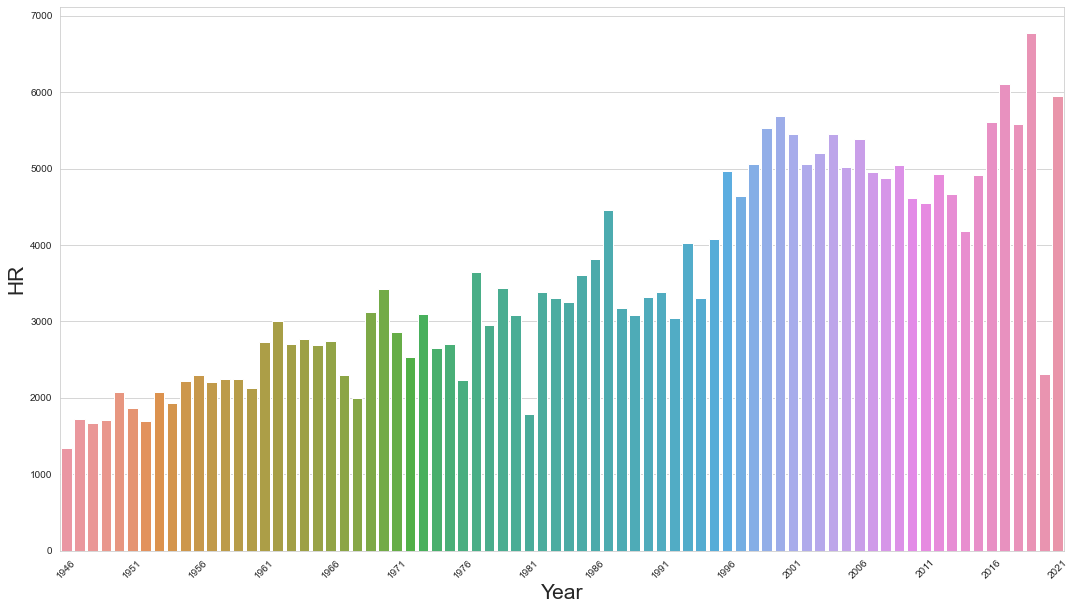

In [87]:

sns.set_style('whitegrid')
sns.set_palette('viridis')


plt.figure(figsize=(18,10))


HRgraph = sns.barplot(x= 'Year', y = 'HR', data = HomerDF)

HRgraph.set_xlabel("Year",fontsize=21)
HRgraph.set_ylabel("HR",fontsize=21)
plt.xticks(np.arange(0, 77, 5), rotation = 45)


([<matplotlib.axis.XTick at 0x250be8fc100>,
 [Text(0, 0, '1946'),
  Text(1, 0, '1947'),
  Text(2, 0, '1948'),
  Text(3, 0, '1949'),
  Text(4, 0, '1950'),
  Text(5, 0, '1951'),
  Text(6, 0, '1952'),
  Text(7, 0, '1953'),
  Text(8, 0, '1954'),
  Text(9, 0, '1955'),
  Text(10, 0, '1956'),
  Text(11, 0, '1957'),
  Text(12, 0, '1958'),
  Text(13, 0, '1959'),
  Text(14, 0, '1960'),
  Text(15, 0, '1961')])

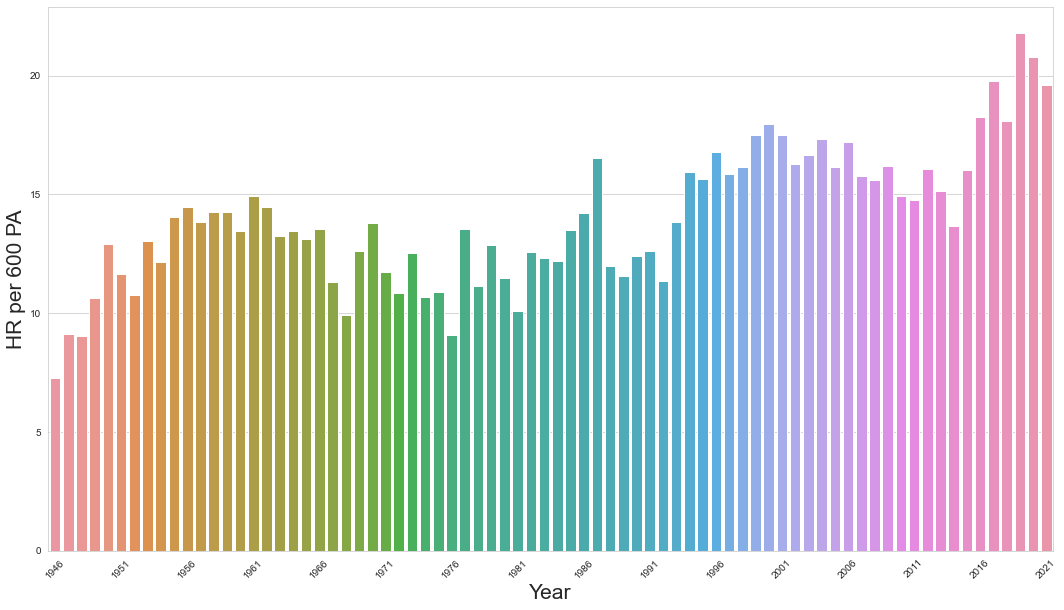

In [88]:
sns.set_style('whitegrid')
sns.set_palette('viridis')


plt.figure(figsize=(18,10))


HRPAgraph = sns.barplot(x= 'Year', y = 'HR per 600 PA', data = HomerDF)

HRPAgraph.set_xlabel("Year",fontsize=21)
HRPAgraph.set_ylabel("HR per 600 PA",fontsize=21)
plt.xticks(np.arange(0, 77, 5), rotation = 45)



In [140]:
# Testing different cursors for datasets

FiftyClub = stats.find({'PA': {'$gte': 50}},{'HR':1, 'PA':1, 'R':1, 'H':1, '2B':1, 'RBI':1, 'BB':1, 'SO':1})

FiftyClub2 = stats.find({'PA': {'$gte': 50}},{'HR':1, 'PA':1, 'R':1, 'H':1, '2B':1, 'RBI':1, 'BB':1, 'SO':1, 'OPS':1})

In [141]:
# build actual dataframe for analysis

LRdf = pd.DataFrame(list(FiftyClub))
LRdf.rename(columns={'2B': 'Db'}, inplace=True)
LRdf.drop(['_id'], axis=1, inplace=True)

In [147]:
LRdf.to_csv('modelDF.csv', index=False)

LRdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36270 entries, 0 to 36269
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PA      36270 non-null  int64  
 1   R       36270 non-null  int64  
 2   H       36270 non-null  int64  
 3   Db      36270 non-null  int64  
 4   HR      36270 non-null  int64  
 5   RBI     36270 non-null  int64  
 6   BB      36270 non-null  int64  
 7   SO      36270 non-null  float64
dtypes: float64(1), int64(7)
memory usage: 2.2 MB


In [124]:
# Model summary from model testing

y, X = patsy.dmatrices('HR ~ PA + R + H + Db + RBI + BB + SO',
                       data=LRdf, return_type="dataframe")

# Create your model
model2 = sm.OLS(y, X)

# Fit your model to your training set
fit2 = model2.fit()

# Print summary statistics of the model's performance
fit2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HR   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 4.329e+04
Date:                Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:13:12   Log-Likelihood:                -90487.
No. Observations:               36270   AIC:                         1.810e+05
Df Residuals:                   36262   BIC:                         1.811e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6986      0.030    -23.155      0.000      -0.758      -0.639
PA            -0.0194      0.001    -36.143      0.000      -0.020      -0.018
R              0.1497      0.002     70.467      0.000       0.146       0.154
H             -0.0668      0.002    -29.904      0.000      -0.071      -0.062
Db            -0.1010      0.004    -25.977      0.000      -0.109      -0.093
RBI            0.3408      0.001    245.507      0.000       0.338       0.344
BB             0.0038      0.002      2.532      0.011       0.001       0.007
SO             0.0679      0.001     80.685      0.000       0.066       0.070
==============================================================================
Omnibus:                     3047.050   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18064.186
Skew:                           0.152   Prob(JB):                         0.00
Kurtosis:                       6.444   Cond. No.                         758.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
# split datasets

HomeRuns = LRdf.loc[:,'HR']
Variables = LRdf.copy()
Variables.drop(['HR'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(Variables, HomeRuns, test_size=0.2,random_state=5)

In [131]:
Variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36270 entries, 0 to 36269
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PA      36270 non-null  int64  
 1   R       36270 non-null  int64  
 2   H       36270 non-null  int64  
 3   Db      36270 non-null  int64  
 4   RBI     36270 non-null  int64  
 5   BB      36270 non-null  int64  
 6   SO      36270 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 1.9 MB


In [132]:
model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8919053044768451
0.8976221090277573


In [136]:
feature_names = []
for col in Variables.columns:
    feature_names.append(col)


In [146]:
model.feature_names = feature_names

In [ ]:
# save model as pickle

with open('predictor_app/models/lr.pk1', 'wb') as f:
    pk1.dump(model, f)

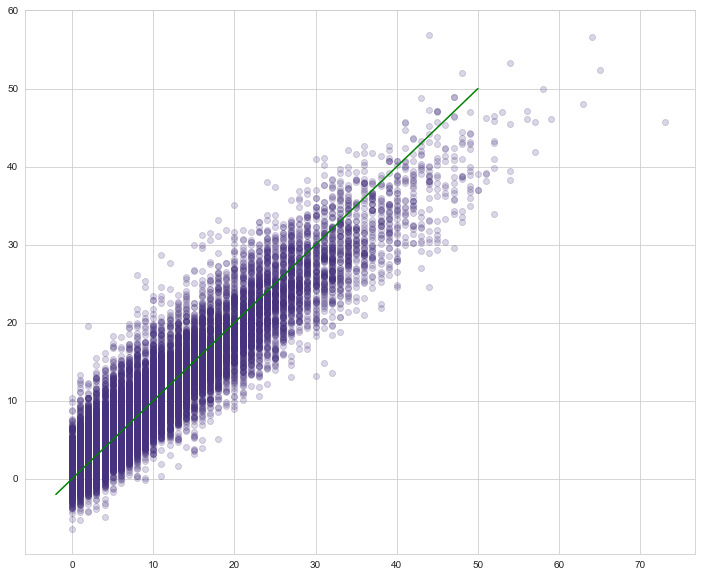

In [159]:
# Fitted vs. Actual
y_train_pred = model.predict(X_train)

plt.figure(figsize=(12,10))

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([-2, 50], [-2, 50], color='green')